In [1]:
import csv
import pandas as pd
import numpy as np
import os
import fnmatch
import glob
import math
import datetime
import matplotlib.pyplot as plt
from scipy import signal
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

('Total: ', 487212)


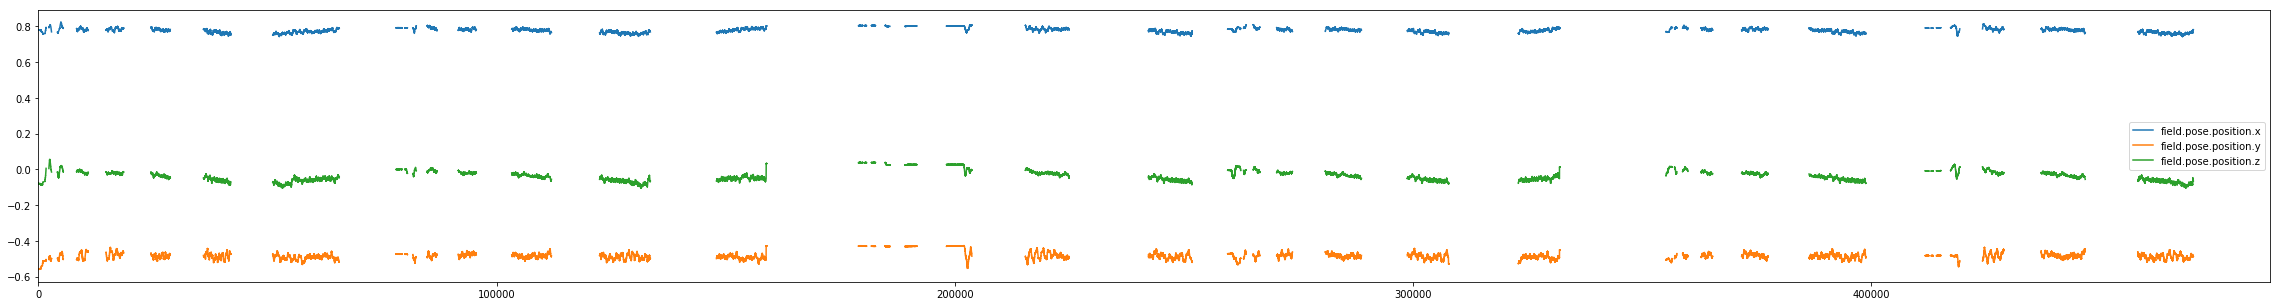

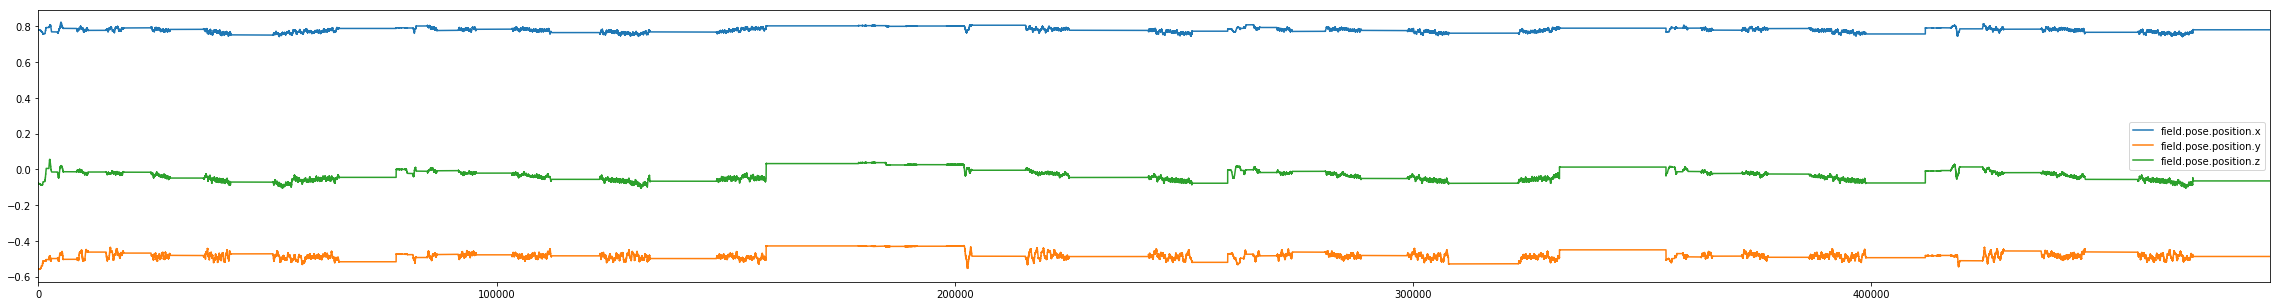

In [76]:

def first_n_digits(num, n):
    return num // 10 ** (int(math.log(num, 10)) - n + 1)



#TO_ITERATE: 1/3 change path STABLE/UNSTABLE
#path = '/Users/ainur/Documents/Codes/RNN/BAXTER_raw_/Traj_1 Pick_and_Place/UNSTABLE/'
path = '/Users/ainur/Documents/Codes/RNN/BAXTER_raw_/Traj_ 2 Cocktail_shake/UNSTABLE/'

#TO_ITERATE: 2/3 change number of files: Traj1: ST: 5, UNST: 6, Traj2: ST: 5, UNST: 6. 
num_files = 6

#TO_ITERATE: 4/4 change path to output file 
path_to_synced_data = 'Data/Method 2 Timestamp/Non-labelled/traj2_unstable.csv'


def myround(num):
    working = str(num-int(num))
    for i, e in enumerate(working[2:]):
        if e != '0':
            return int(num) + float(working[:i+4])
        
#def labeling(df):
    #TODO: Read IMU positions, if  a change in y(?) axis exceeds a treshhold, label all row as UNSTABLE, if not STABLE


def sync_sensors_timestamp(trial_n):
    #Synchronization 

    #all_data_tuple = []
    new_data = pd.DataFrame(columns =['%time'])
    
    #Transmitting the data from files 
    for dirpath, dirnames, filenames in os.walk(path):
        #if fnmatch.fnmatch(file, '*[!p][!y]'):
       
        #iterate through every csv files
        for filename in [ f for f in filenames if f.endswith('.csv') ]:
  

            #iterate through trials and combine different sensors data into one file

            if fnmatch.fnmatch( filename, 'trial'+ str(trial_n) + '*' ) : 


                #print (filename)

                data = pd.read_csv( dirpath + '/' + filename )
                
                #print (len(data))

                #new_data = pd.concat([new_data, data], ignore_index=True)
                new_data = pd.merge(new_data, data, how='outer', on='%time', sort=True)

                

   
    new_data= new_data.drop([ 'field.position0', 'field.position1',
                              'field.position9', 'field.position10', 'field.position11', 'field.position12','field.position13', 'field.position14',
                              'field.position15',  'field.velocity0', 'field.velocity1',  'field.velocity9', 'field.velocity10',  'field.velocity11', 
                              'field.velocity16', 'field.velocity12', 'field.velocity13',  'field.velocity14', 'field.velocity15', 'field.velocity16',
                              'field.effort0', 'field.effort1', 'field.effort9', 'field.effort10', 'field.effort11', 'field.effort12','field.effort13', 'field.effort14', 
                              'field.effort15', 'field.effort16', 'field.header.seq_x', 'field.header.stamp_x',
                             'field.header.frame_id_x', 'field.name0', 'field.name1', 'field.name2', 'field.name3',
                             'field.name4', 'field.name5', 'field.name6', 'field.name7', 'field.name8', 'field.name9',
                             'field.name10', 'field.name11', 'field.name12', 'field.name13', 'field.name14',
                             'field.name15', 'field.name16', 'field.header.seq_y', 'field.header.stamp_y',
                             'field.header.frame_id_y'], axis=1)
    
    return new_data
    
def linear_interpolation(df):
    df = df.interpolate(method='linear', axis=0).ffill().bfill()
    return df
    
def polynomial_interpolate(column, i):
    #linear - returns mainly constant values 
    #df = df.interpolate(method='linear', axis=0).ffill().bfill()
    #print ('Upsampling ' + str(i))
    column = pd.Series(column)
    f = column.interpolate(limit_direction='both')
    return f
    

def main():
    df_s = pd.DataFrame([])
    df_u = pd.DataFrame([])
    df_new = pd.DataFrame([])
    list_upsampled = []
    trial_n = num_files
    #for each trial in stable/unstable traj1/traj2
    for i in range (trial_n): 
  
        #merge all trials across sensors by syncing with timestamp
        df_synced_across_trials = sync_sensors_timestamp(i+1)
        
        #1: Linear interpolation 
        #df_interpolated = linear_interpolation(df_synced_across_trials)
        
        #End of 1: Linear interpolation
        
        
        # 2: Polynomial interpoltation
        list_interpolated = []
        for i in range(len(df_synced_across_trials.columns)):
            sampled = polynomial_interpolate(df_synced_across_trials.iloc[:, i], i)
            
            list_interpolated.append(sampled)
          
        df_interpolated = pd.DataFrame(list_interpolated).T  
        
        #End of  2: Polynomial interpoltation
        
    
        #concatenate all trials in single data frame 
        df_u = pd.concat([df_u, df_interpolated], axis = 0)
        
        df_s = pd.concat([df_s, df_synced_across_trials], axis = 0)
       
    

    #print out data before and after upsampling 
    plt.figure(figsize=(40,5))
    axes_1 = plt.gca()
    
    #df_synced_across_trials - data before upsampling
    #print (df_synced_across_trials)
    df_to_plot_1 = df_s[['field.pose.position.x', 'field.pose.position.y', 'field.pose.position.z']].copy()
    df_to_plot_1.reset_index(drop=True, inplace=True)
    #axes_1set_xlim([xmin,xmax])
    axes_1.set_xlim([0,17500])
    df_to_plot_1.plot(ax=axes_1)
    
    plt.figure(figsize=(40,5))
    axes_2 = plt.gca()
    df_to_plot_2 = df_u[['field.pose.position.x', 'field.pose.position.y', 'field.pose.position.z']].copy()
    df_to_plot_2.reset_index(drop=True, inplace=True)
    axes_2.set_xlim([0,50000])
    df_to_plot_2.plot(secondary_y=False, ax=axes_2)
    
    df_u.to_csv(path_to_synced_data)  
    print ('Total: ', len(df_u))
    
if __name__ == "__main__":
    main()

NameError: name 'df_s' is not defined

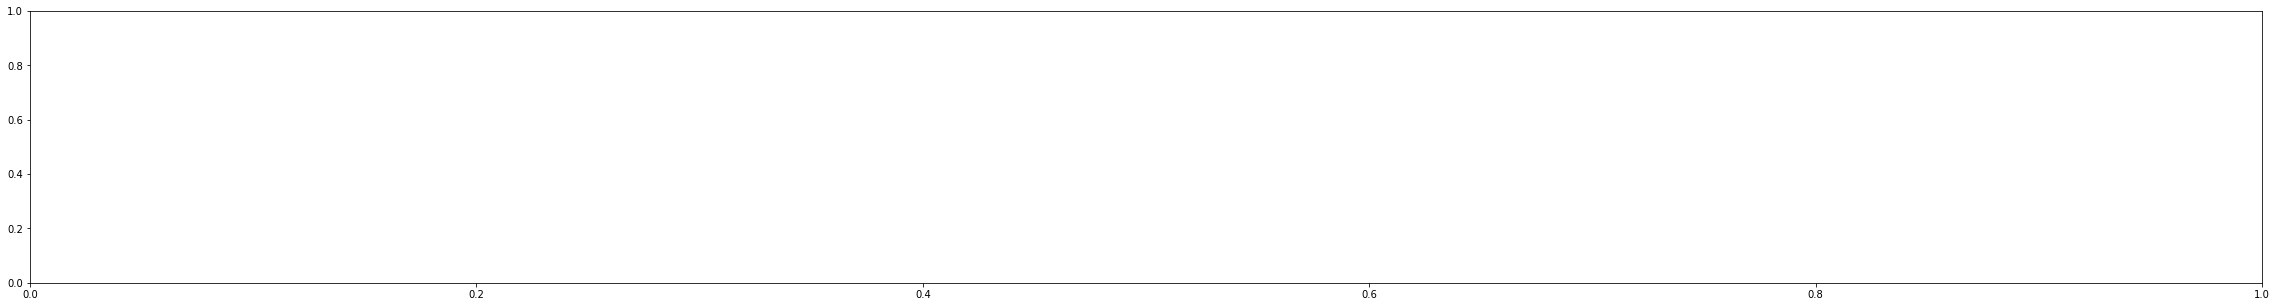

In [72]:
#print out data before and after upsampling 
plt.figure(figsize=(40,5))
axes_1 = plt.gca()

#df_synced_across_trials - data before upsampling
#print (df_synced_across_trials)
df_to_plot_1 = df_s[['field.pose.position.x', 'field.pose.position.y', 'field.pose.position.z']].copy().dropna()
df_to_plot_1.reset_index(drop=True, inplace=True)
#axes_1set_xlim([xmin,xmax])
axes_1.set_xlim([0,17500])
df_to_plot_1.plot(ax=axes_1)

plt.figure(figsize=(40,5))
df_to_plot_2 = df_u[['field.pose.position.x', 'field.pose.position.y', 'field.pose.position.z']].copy()
df_to_plot_2.reset_index(drop=True, inplace=True)
df_to_plot_2.plot(secondary_y=False)

df_u.to_csv(path_to_synced_data)  
print ('Total: ', len(df_u))

[164124 340926 342587 346109]
[164099 340926 342342 344549 348861 419947]
[164124 340926 342587 346109]
[164124 340926 342587 346109]


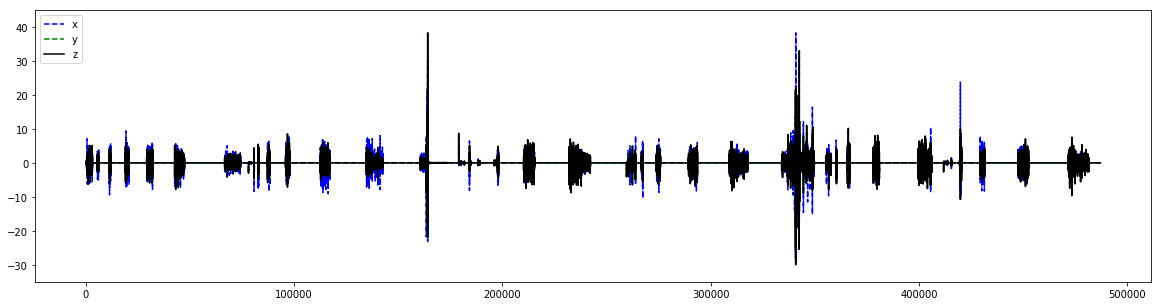

In [60]:
import matplotlib.pyplot as plt
import peakutils
import scipy.fftpack


#Re-Labelling
#
df = pd.read_csv('Data/Method 2 Timestamp/Non-labelled/traj2_unstable.csv')
path_to_labelled = 'Data/Method 2 Timestamp/Labelled Individual/labelled_traj2_unstable.csv'

#First, label all as stable
df['label'] = '1'
#path_to_labelled = 'Processed_data/Data_relabelled/labelled_1.csv'
#df.to_csv(path_to_labelled)



#
#df = pd.read_csv(path_to_synced_data)
fig=plt.figure(figsize=(20,5))
fig.show()
ax=fig.add_subplot(111)

#Caluclate the variations in accelerometer reading

x_diff = df['field.data0'].diff()
y_diff = df['field.data1'].diff()
z_diff = df['field.data1'].diff()


indexes = peakutils.indexes(z_diff, thres=0.6, min_dist=400)
print (indexes)

ax.plot(x_diff,c='b',ls='--',label='x',fillstyle='none')
ax.plot(y_diff,c='g',ls='--',label='y')
ax.plot(z_diff,c='k',ls='-',label='z')
plt.ylim(-35, 45)
plt.legend(loc=2)
plt.draw()

#Get indexes of the rows with high peak values 

x_indexes = peakutils.indexes(x_diff, thres=0.6, min_dist=400)
y_indexes = peakutils.indexes(y_diff, thres=0.6, min_dist=400)
z_indexes = peakutils.indexes(z_diff, thres=0.6, min_dist=400)

print (x_indexes)
print (y_indexes)
print (z_indexes)

#Create new indexes with additional range adding early and later indexes 
add_before = 400
add_after = 0

#for x
new_x_indexes = []
for i in x_indexes: 
    start = i - add_before
    end = i + add_after
    for k  in range(start,end):
        
        new_x_indexes.append(k)
        
#for y
new_y_indexes = []
for i in y_indexes: 
    start = i - add_before
    end = i + add_after
    for k  in range(start,end):
        
        new_y_indexes.append(k)

#for z
new_z_indexes = []
for i in z_indexes: 
    start = i - add_before
    end = i + add_after
    for k  in range(start,end):
        
        new_z_indexes.append(k)
    
#Label rows in new_x_indexes as UNSTABLE
df.loc[df['Unnamed: 0'].isin(new_x_indexes), 'label'] = '0'
df.loc[df['Unnamed: 0'].isin(new_y_indexes), 'label'] = '0'
df.loc[df['Unnamed: 0'].isin(new_z_indexes), 'label'] = '0'

#df['label'] = (df['label'].fillna('1'))
#Save file
df.to_csv(path_to_labelled )


In [65]:
#Delete extra columns
df_1 = pd.read_csv('Data/Method 2 Timestamp/Labelled Individual/labelled_traj1_stable.csv')
df_2 = pd.read_csv('Data/Method 2 Timestamp/Labelled Individual/labelled_traj1_unstable.csv')

df_3 = pd.read_csv('Data/Method 2 Timestamp/Labelled Individual/labelled_traj2_stable.csv')
df_4 = pd.read_csv('Data/Method 2 Timestamp/Labelled Individual/labelled_traj2_unstable.csv')

#Specify which dataframe to concat 
df = pd.concat([df_3, df_4])

df = df.drop(['%time', 'Unnamed: 0', 'Unnamed: 0.1' ], axis=1)

print ("Number of columns: ", len(df.columns))
df.to_csv('Data/Method 2 Timestamp/toRNN_Individual/traj2_data.csv')


('Number of columns: ', 50)


In [31]:
df = pd.read_csv('Data/Synced/Method 1 Upsampled/traj2_stable.csv')
path_to_labelled = 'Data/Relabelled/Method 2 Whole /labelled_traj2_stable.csv'

#First, label all as stable
df['label'] = '1'
df = df.drop(['%time', '%time.1', '%time.2', '%time.3', 'Unnamed: 0', 
              'field.header.seq', 'field.header.seq.1','field.header.stamp', 'field.header.stamp.1', 
              'field.header.frame_id', 'field.header.frame_id.1', 'field.position0', 'field.position1',
              'field.position9', 'field.position10', 'field.position11', 'field.position12','field.position13', 'field.position14',
              'field.position15',  'field.velocity0', 'field.velocity1',  'field.velocity9', 'field.velocity10',  'field.velocity11', 
              'field.velocity16', 'field.velocity12', 'field.velocity13',  'field.velocity14', 'field.velocity15', 'field.velocity16',
              'field.effort0', 'field.effort1', 'field.effort9', 'field.effort10', 'field.effort11', 'field.effort12','field.effort13', 'field.effort14', 
              'field.effort15', 'field.effort16', 'field.header.frame_id', 'field.header.frame_id.1', 
              ], axis=1)
#path_to_labelled = 'Processed_data/Data_relabelled/labelled_1.csv'
df.to_csv(path_to_labelled)

In [34]:
#Delete extra columns
df_1 = pd.read_csv('Data/Relabelled/Method 2 Whole /labelled_traj1_stable.csv')
df_2 = pd.read_csv('Data/Relabelled/Method 2 Whole /labelled_traj1_unstable.csv')
df_3 = pd.read_csv('Data/Relabelled/Method 2 Whole /labelled_traj2_stable.csv')
df_4 = pd.read_csv('Data/Relabelled/Method 2 Whole /labelled_traj2_unstable.csv')

#Specify which dataframe to concat 
df = pd.concat([df_3, df_4])

print ("Number of columns: ", len(df.columns))
df.to_csv('Data/toRNN/traj2_data.csv')
print ("Saved to Data/toRNN/traj2_data.csv")

('Number of columns: ', 51)
Saved to Processed_data/DAta_toRNN/traj2_data.csv
